We need to optimize our model for inference to deploy it in a production environment where there is a strict constraints on available power and memory.  

<u>*There are two options:*</u>
1) *Weight pruning*: We can lower the number parameters in the layers of our model by only keeping the most significant ones. But we have to find a trade-off between *size* and *accuracy*.

2) *Weight quantization*: In general models are trained  with single-precision
floating-point (float32) weights. We can *quantize* weights to 8-bit signed integers (int8) to get an inference-only model that’s a quarter the size . We loose some *accuracy* but we win in *speed*.

<u>*Deep dive into Keras framework*</u>

We can use a specification for the the inputs that will be respected by the others layers 
The *input* layer is a *Symbolic Tensor*

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense , Input
import numpy as np

*Important :*  

In the parameter *shape* in the input the tuple is giving these information: *(Number of features , None (dimension of the batch))*

It's not saying that (in our example) there is 3 samples and N features . It's very confusion but we have to deal with it !

<u>*Here is a simple analogy :*</u>
- Dense(64) creates a machine (coffe machine for example)
- Dense(64)(inputs) must be seen as a personn puttin coffee in the coffee machine
- Dense(10)(features) must be seen as the final result : the coffee in a mug

In [2]:
inputs = Input(shape=(3,), name="Input_specification_layer")
inputs.shape

(None, 3)

In [3]:
features = Dense(units=64,activation="relu")(inputs)
features.shape

2025-09-21 16:10:03.029027: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-09-21 16:10:03.029054: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-09-21 16:10:03.029058: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: pepito
2025-09-21 16:10:03.029060: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] hostname: pepito
2025-09-21 16:10:03.029151: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] libcuda reported version is: 550.163.1
2025-09-21 16:10:03.029165: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:194] kernel reported version is: 550.163.1
2025-09

(None, 64)

In [4]:
outputs = Dense(units=10, activation="softmax")(features)
model = keras.Model(inputs= inputs, outputs= outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_specification_layer       │ (None, 3)              │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

# *Multi-input and multi output models*

# Inputs
Our system takes **three inputs**:

1. **Ticket title** (text)  
2. **Ticket body** (text)  
3. **User tags** (categorical, one-hot encoded)  

> Text inputs are encoded as arrays of 0s and 1s (size = vocabulary_size (number of different words used).

# Outputs
Our model produces **two outputs**:

1. **Priority score** (scalar between 0 and 1, sigmoid)  
2. **Department assignment** (softmax over departments)


In [5]:
vocab_size = 10000
num_tags = 100
num_departments = 4

#We first define our model inputs #
title = Input(shape=(vocab_size,),name="title")
text = Input(shape=(vocab_size,),name="text")
tags= Input(shape=(num_tags,),name="tags")

features = keras.layers.Concatenate()([title,text,tags])
features = Dense(64,activation="relu")(features)

priority = Dense(1,activation="sigmoid", name= "priority")(features)
department = Dense(num_departments,activation="softmax",name="department")(features)

#We finally create a model by specifying its inputs and outputs
model = keras.Model(inputs = [title,text,tags], outputs=[priority,department])

*Let's create some dummy values to train our model*

In [6]:
num_samples = 1280

#The high boundary is excluded (this is why we take 2 and not 1)

title_data =np.random.randint(low=0, high=2 ,size=((num_samples,vocab_size)))
text_data = np.random.randint(low=0, high=2 ,size=((num_samples,vocab_size)))
tags_data = np.random.randint(low=0, high=2 ,size=((num_samples,num_tags)))

#Random flaoat32 between 0 and 1 for the priority
priority_data = np.random.random(size=(num_samples,1))
department_data = np.random.randint(0,2,size=(num_samples,num_departments))

model.compile(optimizer="rmsprop",
              loss = ["mse","categorical_crossentropy"],
               metrics=[["mean_absolute_error"], ["accuracy"]])

history = model.fit(
    [title_data,text_data,tags_data],
    [priority_data,department_data],
    epochs = 1
)
eval = model.evaluate(
    [title_data, text_data, tags_data],
    [priority_data, department_data]
)

priority_preds, department_preds = model.predict(
    [title_data, text_data, tags_data]
)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - department_accuracy: 0.2805 - department_loss: 28.1631 - loss: 28.4981 - priority_loss: 0.3351 - priority_mean_absolute_error: 0.5026
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - department_accuracy: 0.1305 - department_loss: 14.3482 - loss: 14.6870 - priority_loss: 0.3387 - priority_mean_absolute_error: 0.5069
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


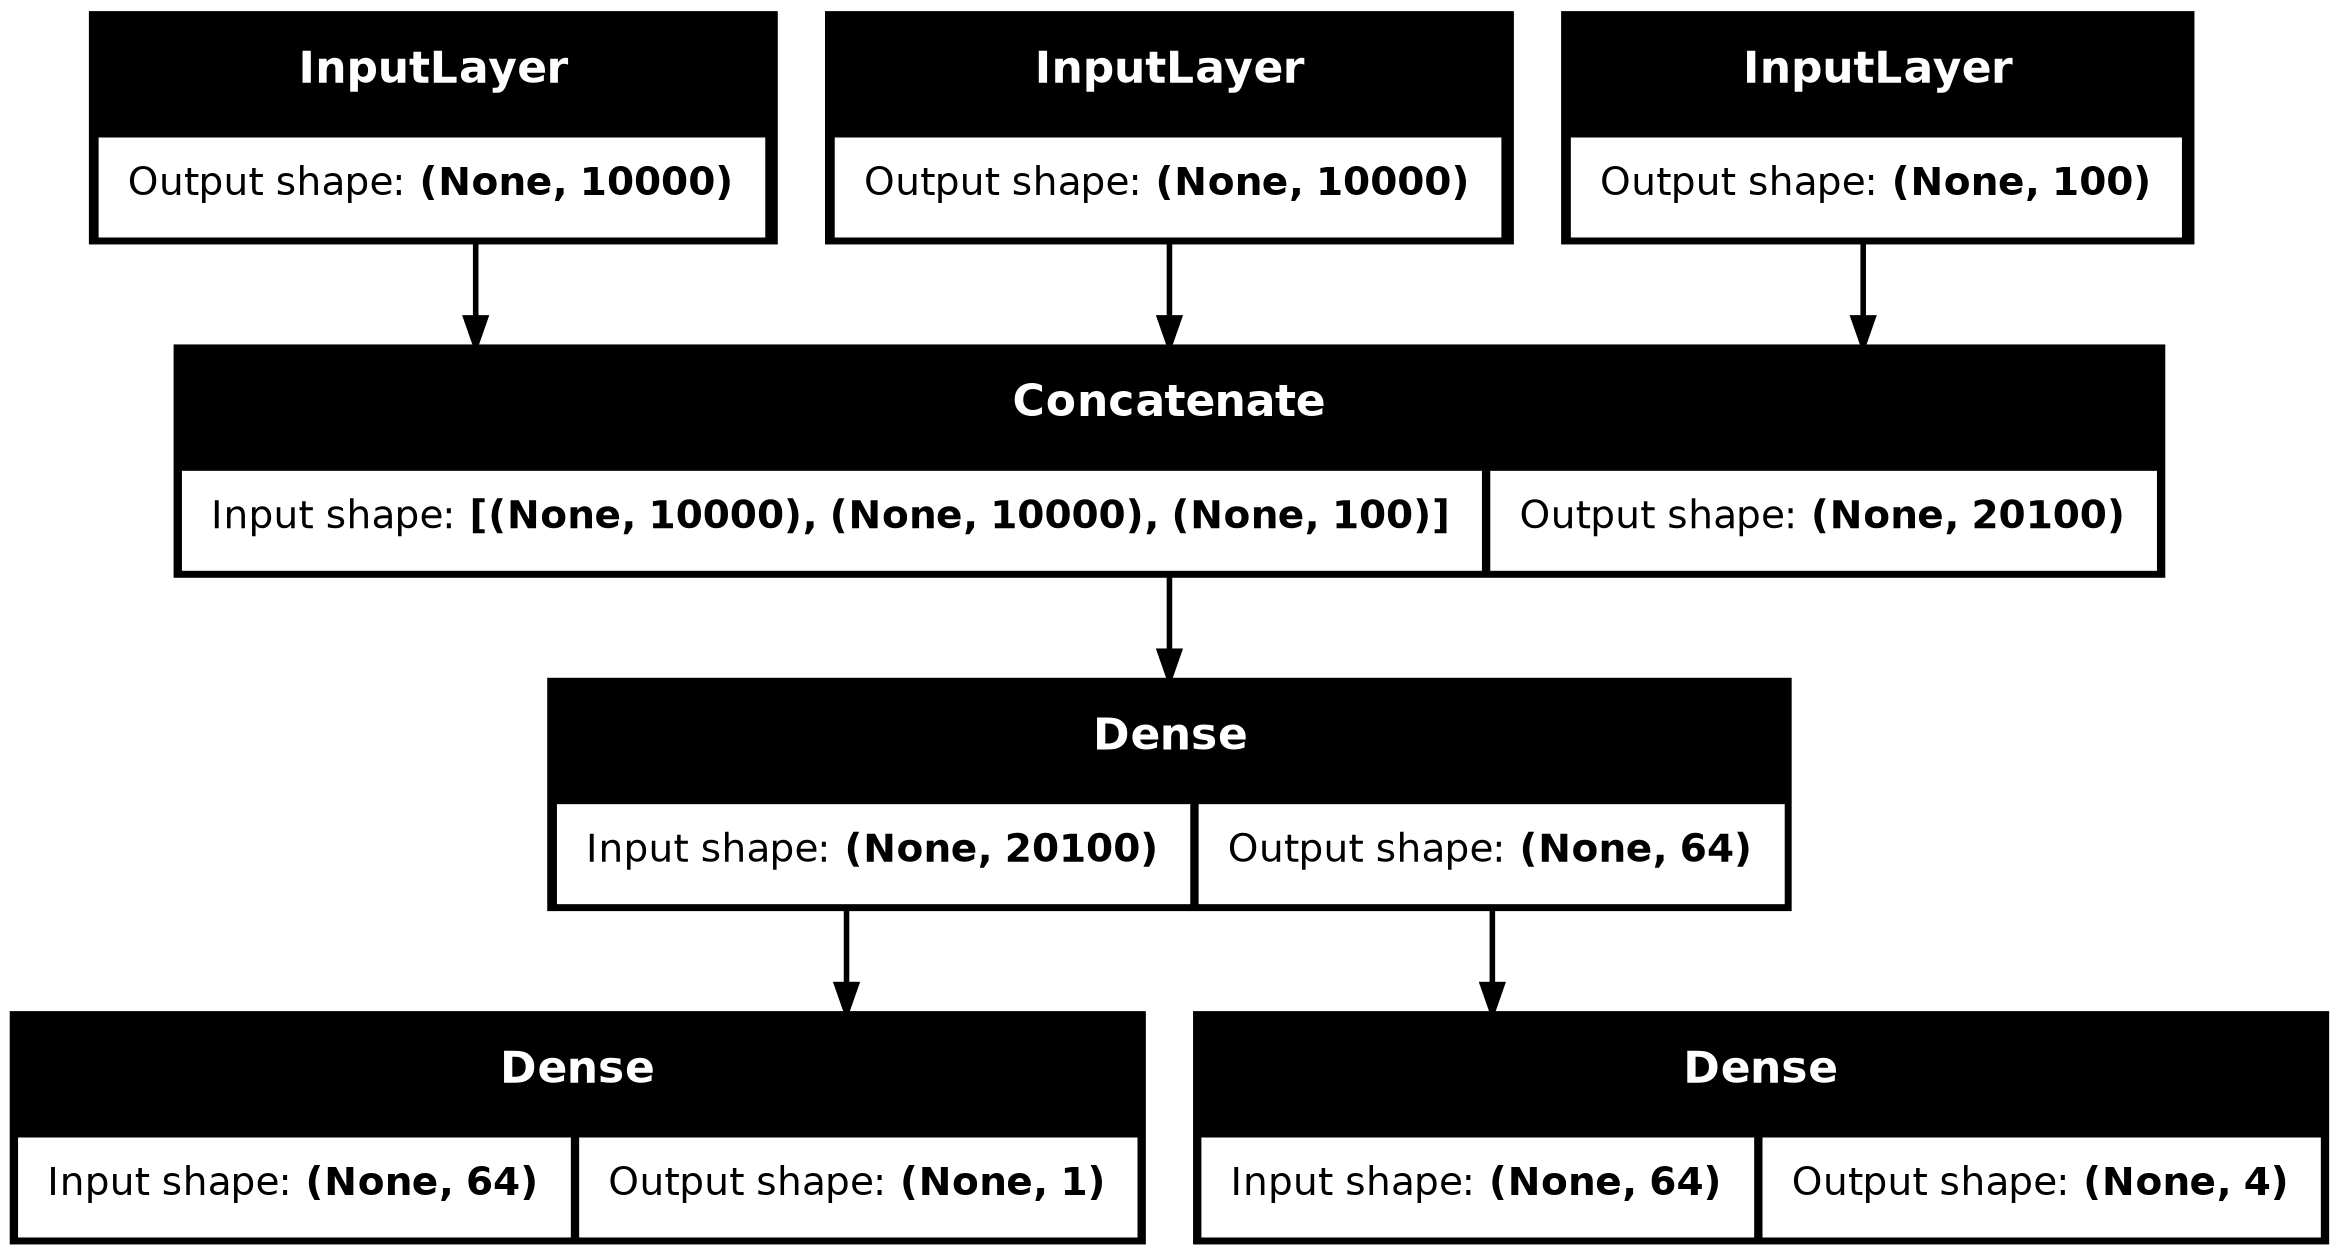

In [12]:
keras.utils.plot_model(model,'ticket.png', show_shapes=True)

*Now we can reuse intermediate layer outputs to add another output to the model without retraining it from the beginning*

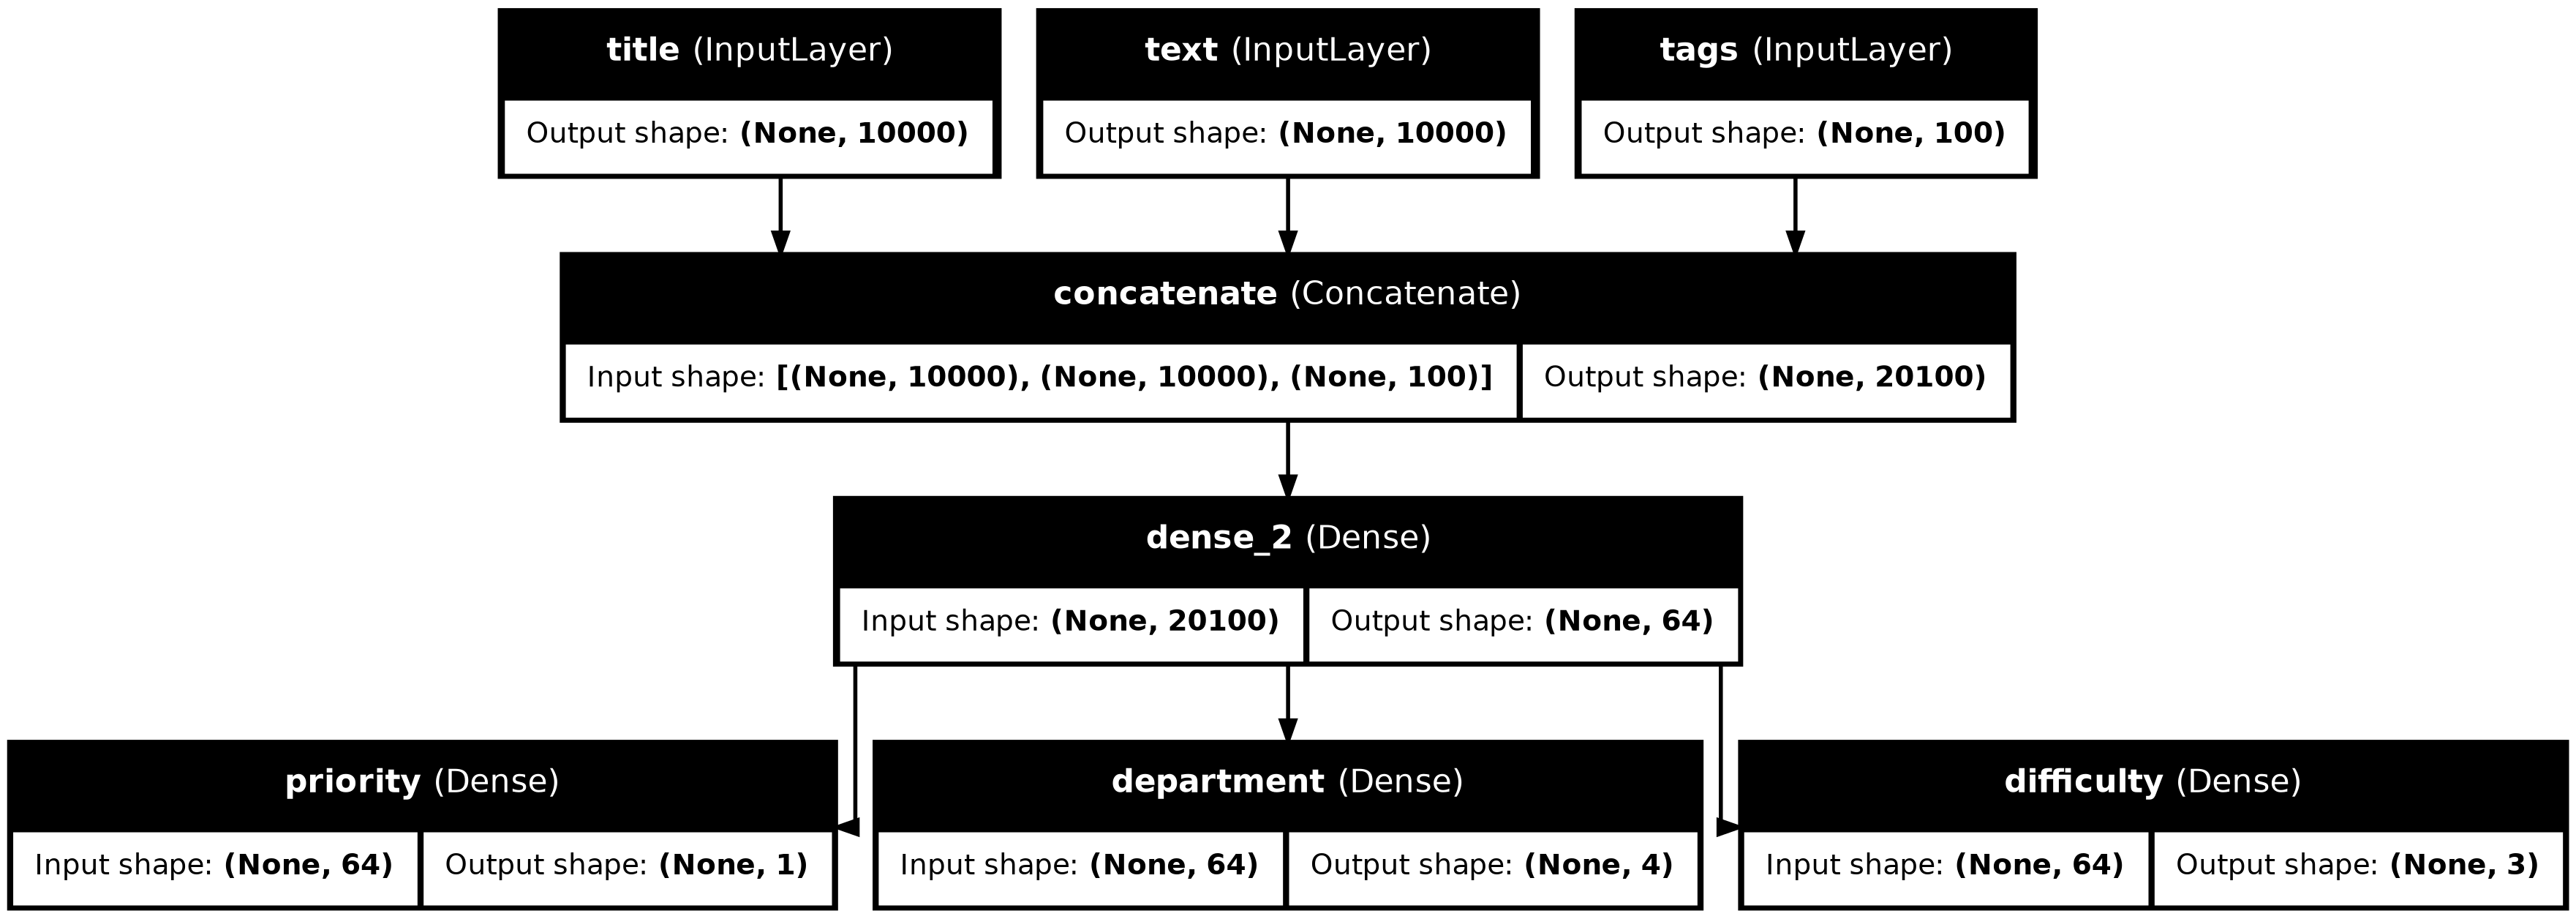

In [18]:
features = model.layers[4].output
difficulty = Dense(3,activation="softmax",name="difficulty")(features)

new_model = keras.Model(
    inputs= [title,text,tags],
    outputs=[priority,department,difficulty]
)

keras.utils.plot_model(new_model,'Ticket2.png', show_shapes=True, show_layer_names=True)

# CallBacks 


- A callback is an object that is passed to the model in the call to fit() and that is called by the model at various points during training. 

- It has access to all the available data about the state of the
model and its performance, and it can take action

*There are different types of callbacks:*
- The <u>EarlyStopping</u> callback interrupts training once a target metric being moni-
tored has stopped improving for a fixed number of epochs

- The <u>ModelCheckPoint</u> lets us continually save the model during the training

In [35]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.datasets import mnist
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [50]:
(X_train,Y_train),(X_test,Y_test) = mnist.load_data()
X_train_flat = X_train.reshape(X_train.shape[0],28*28).astype("float32")/255.0
X_test_flat = X_test.reshape(X_test.shape[0],28*28).astype("float32")/255.0

k = 5
kf = KFold(n_splits=k, shuffle=True,random_state=42)
fold_number = 1
scores= []
histories = []

In [51]:
for train_index,val_index in kf.split(X_test_flat):
    print(f"Fold number{fold_number}")
    
    X_tr , X_val = X_train_flat[train_index], X_train_flat[val_index]
    Y_tr, Y_val = Y_train[train_index], Y_train[val_index]
    
    model = keras.models.Sequential(
        [Dense(64,activation="relu"),
        Dense(512,activation="relu"),
        Dense(10,activation="softmax")]
    )

    model.compile(
        optimizer="rmsprop",
        loss ="sparse_categorical_crossentropy",
        metrics = ["accuracy"]
        )

    #Let use ou callback

    #The patience attribute interrupts training when accuracy has stopped improving for two epoch

    callbacks = [
        EarlyStopping(monitor="val_accuracy",patience=2, restore_best_weights=True),
        ModelCheckpoint(filepath='checkpoint.keras',monitor="val_loss",save_best_only= True)
    ]
    history = model.fit(X_tr,Y_tr,epochs=20,batch_size=32,callbacks= callbacks, validation_data=(X_val,Y_val), verbose=1)
    histories.append(history) 
    
    #Let's evaluate the model
    score = model.evaluate(X_val,Y_val, verbose=0)
    print(f"Validation accuracy: {score[1]}")
    scores.append(score[1])
    fold_number +=1
    


Fold number1
Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8397 - loss: 0.5493 - val_accuracy: 0.9185 - val_loss: 0.2822
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9250 - loss: 0.2616 - val_accuracy: 0.9295 - val_loss: 0.2408
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9436 - loss: 0.1832 - val_accuracy: 0.9385 - val_loss: 0.1926
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9578 - loss: 0.1432 - val_accuracy: 0.9530 - val_loss: 0.1625
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9670 - loss: 0.1095 - val_accuracy: 0.9520 - val_loss: 0.1681
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9735 - loss: 0.0892 - val_accuracy: 0.9520 - val_loss: 0.1828
Validation accuracy: 0.953000009059906
Fold number2
Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8468 - loss: 0.5298 - val_accuracy: 0.9010 - val_loss: 0.3403
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━

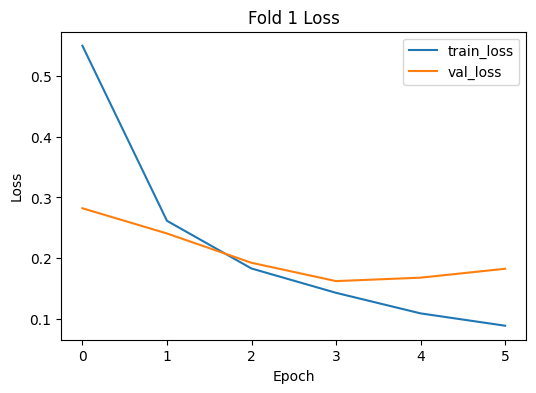

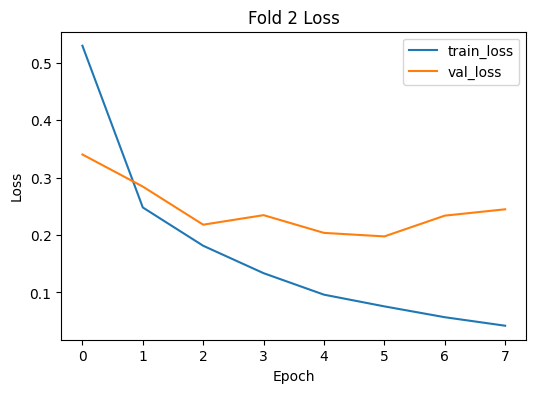

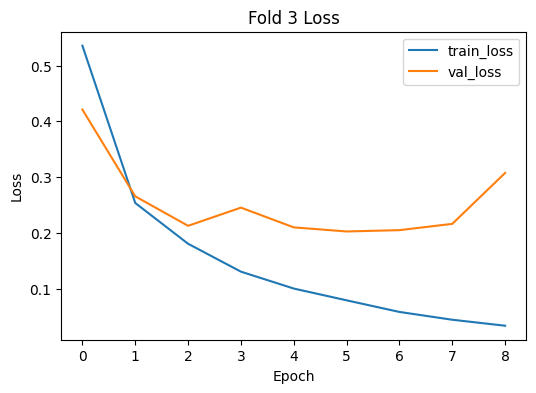

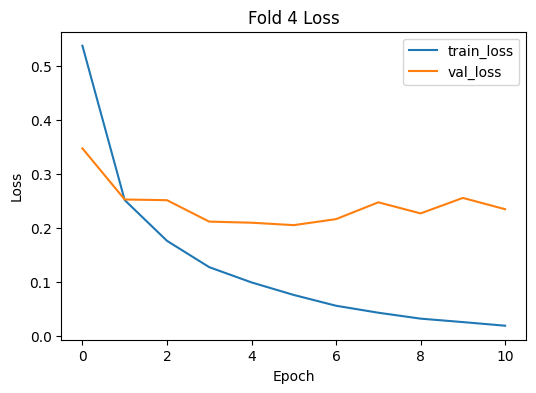

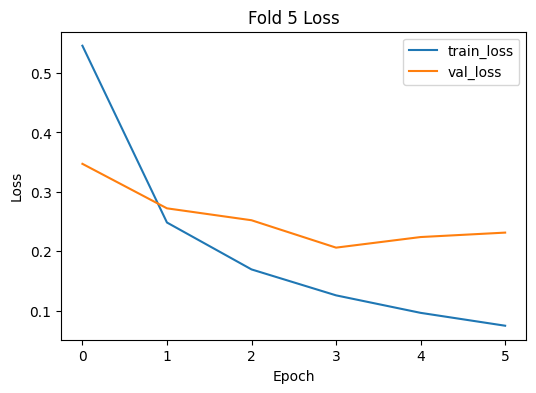

In [53]:
for i, history in enumerate(histories, 1):
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

histories